# Fraud Detection System
# By : Hitesh Thadhani, Aditya Sai Yerraguntla, Surjit Singh
# App Link: https://fraud-detection-system.herokuapp.com/

## 0. Import Statements

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import fancyimpute
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,Normalizer
from sklearn.metrics import accuracy_score,recall_score,classification_report,precision_score,roc_auc_score,f1_score,roc_curve, confusion_matrix
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import pickle
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


## 1. Data Merging and Stratified Sampling 

In [ ]:
df = pd.read_csv('train_transaction.csv')

In [ ]:
df.head()

In [ ]:
df_i = pd.read_csv('train_identity.csv')

In [ ]:
df_i.head()

## 1.1 Data Merging Transaction and Identity 

In [ ]:
df_merged = pd.merge(df, df_i, on='TransactionID', how='left')

In [ ]:
df_merged.head()

In [ ]:
df_merged.shape

In [ ]:
df_merged.isFraud.value_counts(normalize=True)

## 1.2 Stratified Sampling

In [ ]:
X = df_merged.drop(['isFraud'],axis=1)

In [ ]:
y = df_merged[['isFraud']]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.83, random_state=42, stratify=y)

In [ ]:
y_train.isFraud.value_counts(normalize=True)

In [ ]:
strat_data = pd.concat([X_train,y_train],axis=1)

In [ ]:
strat_data.to_csv('Stratified_sampling_fraud.csv')

## 2. Data Preprocessing

In [ ]:
df_fraud = pd.read_csv('Stratified_sampling_fraud.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (416,420) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
len(df_fraud)

100391

### 2.1 Dropping NA columns

#### Using below code we wll be dropping columns which have more the 50% or null values

In [ ]:
cols_to_drop = list(df_fraud.columns[df_fraud.isnull().sum() * 100 / len(df_fraud)>50])
df_fraud2 = df_fraud.drop(columns = cols_to_drop)
df_fraud2 = df_fraud2.drop(columns=['Unnamed: 0'])  

## Creating 2 new features Day of the Week and Hour of the Day from the existing TransactionDT feature

In [ ]:
df_fraud2['Day_of_Week_Tx'] = np.floor((df_fraud2['TransactionDT'] / (3600 * 24) - 1) % 7)
df_fraud2['Hour_of_Day_Tx'] = np.floor(df_fraud2['TransactionDT'] / 3600) % 24

In [ ]:
df_fraud2.shape

(100391, 222)

### 2.2 Imputing quantitative vairables using Mice Imputer

In [ ]:
df_num = df_fraud2.select_dtypes(include=np.number)

In [ ]:
MICE_imputer = fancyimpute.IterativeImputer()

In [ ]:
fraud_col = df_num['isFraud']

In [ ]:
df_num = df_num.drop(columns=['isFraud'])

In [ ]:
scaler = StandardScaler()
scaled_df_num = scaler.fit_transform(df_num)

In [ ]:
df_num2 = pd.DataFrame(scaled_df_num, columns=df_num.columns, index=df_num.index)

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
df_temp_num = pd.DataFrame(data = MICE_imputer.fit_transform(df_num2.values),columns=df_num2.columns, index=df_num2.index)

In [ ]:
df_temp_num.to_csv(r'mice_num.csv')

In [ ]:
pd.set_option('max_columns', 99999)
pd.set_option('max_rows', 99999)

### 2.2 Imputing categorical variables with Mode

In [ ]:
df_cat = df_fraud2.select_dtypes('object')

In [ ]:
df_cat['TransactionAmt'] = df_fraud2['TransactionAmt']

In [ ]:
df_cat.isnull().sum()

ProductCD             0
card4               274
card6               274
P_emaildomain     16109
M1                46367
M2                46367
M3                46367
M4                47693
M6                28923
TransactionAmt        0
dtype: int64

In [ ]:
df_cat.isnull().sum() * 100 / len(df_cat)

ProductCD          0.000000
card4              0.272933
card6              0.272933
P_emaildomain     16.046259
M1                46.186411
M2                46.186411
M3                46.186411
M4                47.507247
M6                28.810352
TransactionAmt     0.000000
dtype: float64

In [ ]:
df_cat.describe()

,TransactionAmt
count,100391.000000
mean,134.592726
std,249.175029
min,0.272000
25%,42.950000
50%,68.950000
75%,125.000000
max,31937.391000


In [ ]:
df_cat.groupby(['ProductCD'])['card4'].value_counts()

ProductCD  card4           
C          visa                 7031
           mastercard           4702
H          visa                 3953
           mastercard           1328
           american express      270
           discover               99
R          visa                 3858
           mastercard           1289
           american express     1055
           discover              181
S          visa                 1112
           mastercard            665
           american express      112
           discover               95
W          visa                49435
           mastercard          24219
           discover              713
Name: card4, dtype: int64

In [ ]:
df_cat.groupby(['card4'])['TransactionAmt'].median()

card4
american express    125.00
discover            117.00
mastercard           63.97
visa                 68.50
Name: TransactionAmt, dtype: float64

In [ ]:
df_cat.groupby(['card6'])['TransactionAmt'].median()

card6
charge card         50.604
credit             100.000
debit               59.000
debit or credit     44.950
Name: TransactionAmt, dtype: float64

In [ ]:
df_fraud.TransactionAmt[df_fraud['card4'].isnull()]

218        108.950
463         39.000
1699        83.950
1744        44.832
2137       613.110
2373       117.000
2457        54.348
2543      1616.800
2811        34.000
2964        57.950
2978        39.000
3396        59.000
3582        59.000
4436       117.000
5438        36.950
5562        57.950
5678       196.990
6039        49.000
6590       109.000
6608       226.000
6794        25.950
6913        19.970
6999       142.470
7126       107.950
7575        36.950
8677       335.000
8690        46.950
8923       734.000
9154       116.470
9196        54.500
9550       117.000
9591       108.950
9818       664.000
9829       130.500
9866       107.950
10295       58.950
10412       58.950
11718       35.950
12321        2.968
12404     1509.570
13093       59.000
13155       37.000
13208       26.129
13554       35.950
13658      107.950
13986      107.950
14098      190.950
14164       87.000
14248       59.000
14791       87.000
15847       97.000
16607       88.950
17240       

In [ ]:
df_fraud.TransactionAmt[df_fraud['card6'].isnull()]

218        108.950
463         39.000
1699        83.950
1744        44.832
2137       613.110
2373       117.000
2457        54.348
2543      1616.800
2811        34.000
2964        57.950
2978        39.000
3396        59.000
3582        59.000
4436       117.000
5438        36.950
5562        57.950
5678       196.990
6039        49.000
6590       109.000
6608       226.000
6794        25.950
6913        19.970
6999       142.470
7126       107.950
7575        36.950
8677       335.000
8690        46.950
8923       734.000
9154       116.470
9196        54.500
9550       117.000
9591       108.950
9818       664.000
9829       130.500
9866       107.950
10295       58.950
10412       58.950
11718       35.950
12321        2.968
12404     1509.570
13093       59.000
13155       37.000
13208       26.129
13554       35.950
13658      107.950
13986      107.950
14098      190.950
14164       87.000
14248       59.000
14791       87.000
15847       97.000
16607       88.950
17240       

In [ ]:
df_cat.M1.value_counts()

T    54016
F        8
Name: M1, dtype: int64

In [ ]:
df_cat.M2.value_counts()

T    48277
F     5747
Name: M2, dtype: int64

In [ ]:
df_cat.M3.value_counts()

T    42598
F    11426
Name: M3, dtype: int64

In [ ]:
df_cat.M4.value_counts()

M0    33329
M2    10283
M1     9086
Name: M4, dtype: int64

In [ ]:
df_cat.M6.value_counts()

F    38804
T    32664
Name: M6, dtype: int64

In [ ]:
df_cat['P_emaildomain'].fillna('unknown',inplace=True)

In [ ]:
def email_first(email):
  return email.split('.')[0]

In [ ]:
df_cat['emaild'] = df_cat[~df_cat['P_emaildomain'].isnull()]['P_emaildomain'].apply(email_first)

In [ ]:
def mode_impute(df,col):
  df[col].fillna(df[col].mode()[0], inplace=True)

In [ ]:
mode_impute(df_cat,'M1')


In [ ]:
mode_impute(df_cat,'M2')


In [ ]:
mode_impute(df_cat,'M3')


In [ ]:
mode_impute(df_cat,'M4')


In [ ]:
mode_impute(df_cat,'M6')


In [ ]:
df_cat.isnull().sum()

ProductCD           0
card4             274
card6             274
P_emaildomain       0
M1                  0
M2                  0
M3                  0
M4                  0
M6                  0
TransactionAmt      0
emaild              0
dtype: int64

In [ ]:
df_cat.drop(columns='P_emaildomain',inplace=True)

In [ ]:
df_cat.isnull().sum()

ProductCD           0
card4             274
card6             274
M1                  0
M2                  0
M3                  0
M4                  0
M6                  0
TransactionAmt      0
emaild              0
dtype: int64

In [ ]:
df_cat.groupby(['card4'])['TransactionAmt'].median()

card4
american express    125.00
discover            117.00
mastercard           63.97
visa                 68.50
Name: TransactionAmt, dtype: float64

In [ ]:
def impute_card4(amt):
  if amt <= 64:
    return 'mastercard'
  elif amt >=65 and amt <=115:
    return 'visa'
  elif amt>=116 and amt <=124:
    return 'discover'
  else:
    return 'american express'

In [ ]:
df_cat['card4_new'] = df_cat.apply(lambda x: impute_card4(x.TransactionAmt) if pd.isnull(x.card4) else x.card4,axis=1)
df_cat = df_cat.drop(columns=["card4"])

In [ ]:
df_cat.isnull().sum()

ProductCD           0
card6             274
M1                  0
M2                  0
M3                  0
M4                  0
M6                  0
TransactionAmt      0
emaild              0
card4_new           0
dtype: int64

In [ ]:
df_cat[df_cat['card4'].isna()]

,ProductCD,card4,card6,M1,M2,M3,M4,M6,TransactionAmt,emaild
218,W,NaN,NaN,T,T,F,M0,T,108.950,gmail
463,W,NaN,NaN,T,T,T,M0,F,39.000,gmail
1699,W,NaN,NaN,T,T,T,M0,T,83.950,unknown
1744,C,NaN,NaN,T,T,T,M2,F,44.832,hotmail
2137,W,NaN,NaN,T,T,T,M0,F,613.110,me
...,...,...,...,...,...,...,...,...,...,...
98738,W,NaN,NaN,T,T,T,M1,F,388.000,gmail
98934,W,NaN,NaN,T,T,T,M0,T,226.000,gmail
99031,W,NaN,NaN,T,T,T,M0,F,210.950,anonymous
99806,W,NaN,NaN,T,T,T,M0,T,49.000,verizon


In [ ]:
df_cat.groupby(['card6'])['TransactionAmt'].median()

card6
charge card         50.604
credit             100.000
debit               59.000
debit or credit     44.950
Name: TransactionAmt, dtype: float64

In [ ]:
def impute_card6(amt):
  if amt <= 45:
    return 'debit or credit'
  elif amt >=66 and amt <=50:
    return 'charge card'
  elif amt>=51 and amt <=60:
    return 'debit'
  else:
    return 'credit'

In [ ]:
df_cat['card6_new'] = df_cat.apply(lambda x: impute_card6(x.TransactionAmt) if pd.isnull(x.card6) else x.card6,axis=1)
df_cat = df_cat.drop(columns=["card6"])

In [ ]:
df_cat.isnull().sum()

ProductCD         0
M1                0
M2                0
M3                0
M4                0
M6                0
TransactionAmt    0
emaild            0
card4_new         0
card6_new         0
dtype: int64

In [ ]:
df_temp_num.isnull().sum()

TransactionID     0
TransactionDT     0
TransactionAmt    0
card1             0
card2             0
card3             0
card5             0
addr1             0
addr2             0
C1                0
C2                0
C3                0
C4                0
C5                0
C6                0
C7                0
C8                0
C9                0
C10               0
C11               0
C12               0
C13               0
C14               0
D1                0
D2                0
D3                0
D4                0
D10               0
D11               0
D15               0
V1                0
V2                0
V3                0
V4                0
V5                0
V6                0
V7                0
V8                0
V9                0
V10               0
V11               0
V12               0
V13               0
V14               0
V15               0
V16               0
V17               0
V18               0
V19               0
V20               0


In [ ]:
## Here we are concating numberical and categorical imputed data
final_df = pd.concat([df_temp_num, df_cat], axis=1)
final_df

,TransactionID,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D10,D11,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,Day_of_Week_Tx,Hour_of_Day_Tx,ProductCD,M1,M2,M3,M4,M6,TransactionAmt,emaild,card4_new,card6_new
0,0.468796,0.429106,-0.307587,0.249458,-0.106313,-0.283015,0.599090,0.077481,0.074114,-0.098145,-0.092558,-0.036382,-0.059163,-0.176589,-0.112857,-0.045938,-0.053737,-0.208650,-0.054712,-0.097998,-0.046914,-0.189263,-0.147622,0.930379,0.406531,0.046946,1.872612,0.628290,0.495527,1.653359,0.010677,-0.189174,-0.243459,0.353205,0.260853,-0.190884,-0.238351,-0.148361,-0.182704,1.033909,0.945600,0.863531,0.756839,0.022693,-0.371119,-0.365375,-0.366787,-0.364027,0.432053,0.335506,-0.384940,-0.371067,-0.137463,-0.187181,0.117011,0.056998,-0.026743,-0.026599,1.209216,1.083320,-0.398371,-0.390895,-0.385521,-0.392082,-1.045119,-1.070375,1.322058,0.957381,-0.370615,-0.357049,0.027723,-0.409583,-0.390614,1.604073,1.300269,5.862813,3.989506,1.218434,1.112097,-0.443446,-0.425749,-0.415493,0.826666,0.713544,-0.173183,-0.165995,-0.370899,-0.353707,-0.356909,-0.344778,0.391777,0.272658,-0.369874,-0.351078,0.01693,0.088759,0.006815,-0.024553,1.196449,1.075771,-0.389433,-0.371531,-0.384942,-0.389048,-1.055624,-1.091032,-0.166510,-0.182435,-0.358309,-0.351696,-0.340474,0.365371,0.247285,-0.381269,-0.356676,-0.158902,-0.199320,0.027839,-0.026818,1.169787,1.043397,-0.402198,-0.383718,-0.401546,-0.049348,-0.075523,-0.062433,-0.218387,-0.333254,-0.291171,-0.042628,-0.050981,-0.049829,-0.133544,-0.083102,-0.09016,0.017861,-0.057839,-0.11677,-0.080956,-0.038426,-0.064087,-0.047494,-0.084591,-0.171514,-0.114964,-0.014084,-0.036693,-0.023442,-0.023703,-0.066091,-0.0394,-0.138248,-0.250936,-0.181231,-0.056189,-0.080665,-0.068658,-0.070099,-0.290366,-0.183421,-0.045134,-0.054167,-0.052659,-0.082657,-0.096124,-0.093524,-0.053844,-0.071878,-0.172028,-0.892515,-0.625971,-0.263228,-0.353392,-0.168276,-0.330038,-0.430026,-0.39431,-0.124122,-0.040424,-0.061549,-0.045514,-0.059294,-0.055906,-0.100951,-0.141964,-0.093984,-0.099479,-0.154221,-0.163039,-0.523434,-0.452780,-0.501426,0.0,-0.060223,-0.094656,-0.077421,-0.085832,-0.329029,-0.037032,-0.216329,-0.225491,-0.256123,-0.233358,-0.047958,-0.063173,-0.058487,-0.086097,-0.104802,-0.099922,-0.482151,-1.160565,W,T,T,T,M0,T,57.950,comcast,mastercard,debit
1,-0.929721,-0.999674,6.085742,1.186828,-0.258555,-0.283015,-0.103036,0.077481,0.074114,-0.090555,-0.086008,-0.036382,-0.059163,-0.215468,-0.112857,-0.045938,-0.053737,-0.148243,-0.054712,-0.097998,-0.046914,-0.251638,-0.168075,-0.597109,-0.970459,0.511054,0.630161,-0.677875,-0.787244,0.480459,0.010677,-0.189174,-0.243459,0.353205,0.260853,-0.190884,-0.238351,-0.148361,-0.182704,-0.884308,-0.860731,0.863531,0.756839,0.022693,-0.371119,-0.365375,-0.366787,-0.364027,0.432053,0.335506,-0.384940,-0.371067,-0.137463,-0.187181,0.117011,0.056998,-0.026743,-0.026599,-0.755698,-0.731492,-0.398371,-0.390895,-0.385521,-0.392082,0.889149,0.782057,-0.160166,-0.190370,-0.370615,-0.357049,0.027723,-0.409583,-0.390614,-0.142519,-0.177115,-0.136113,-0.167090,-0.752276,-0.731206,-0.443446,-0.425749,-0.415493,0.826666,0.713544,-0.173183,-0.165995,-0.370899,-0.353

In [ ]:
final_df.to_csv(r'final_df.csv')

### 2.3 Dropping correlated variables

In [ ]:
fraud_df = pd.read_csv('final_df.csv')

In [ ]:
strat_df = pd.read_csv('Stratified_sampling_fraud.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (416,420) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
fraud_df['isFraud'] = strat_df['isFraud']
fraud_df = fraud_df.drop(columns=['Unnamed: 0','TransactionAmt.1','TransactionID'])
fraud_df.head()

,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D10,D11,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,...,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,Day_of_Week_Tx,Hour_of_Day_Tx,ProductCD,M1,M2,M3,M4,M6,emaild,card4_new,card6_new,isFraud
0,0.429106,-0.307587,0.249458,-0.106313,-0.283015,0.599090,0.077481,0.074114,-0.098145,-0.092558,-0.036382,-0.059163,-0.176589,-0.112857,-0.045938,-0.053737,-0.208650,-0.054712,-0.097998,-0.046914,-0.189263,-0.147622,0.930379,0.406531,0.046946,1.872612,0.628290,0.495527,1.653359,0.010677,-0.189174,-0.243459,0.353205,0.260853,-0.190884,-0.238351,-0.148361,-0.182704,1.033909,0.945600,...,-0.059294,-0.055906,-0.100951,-0.141964,-0.093984,-0.099479,-0.154221,-0.163039,-0.523434,-0.452780,-0.501426,0.0,-0.060223,-0.094656,-0.077421,-0.085832,-0.329029,-0.037032,-0.216329,-0.225491,-0.256123,-0.233358,-0.047958,-0.063173,-0.058487,-0.086097,-0.104802,-0.099922,-0.482151,-1.160565,W,T,T,T,M0,T,comcast,mastercard,debit,0
1,-0.999674,6.085742,1.186828,-0.258555,-0.283015,-0.103036,0.077481,0.074114,-0.090555,-0.086008,-0.036382,-0.059163,-0.215468,-0.112857,-0.045938,-0.053737,-0.148243,-0.054712,-0.097998,-0.046914,-0.251638,-0.168075,-0.597109,-0.970459,0.511054,0.630161,-0.677875,-0.787244,0.480459,0.010677,-0.189174,-0.243459,0.353205,0.260853,-0.190884,-0.238351,-0.148361,-0.182704,-0.884308,-0.860731,...,-0.059294,-0.055906,-0.100951,-0.141964,-0.093984,-0.099479,-0.154221,-0.163039,-0.523434,-0.452780,-0.501426,0.0,-0.060223,-0.094656,-0.077421,-0.085832,-0.329029,-0.037032,-0.216329,-0.225491,-0.256123,-0.233358,-0.047958,-0.063173,-0.058487,-0.086097,-0.104802,-0.099922,-0.482151,0.941072,W,T,T,F,M2,F,yahoo,visa,debit,0
2,-0.288092,-0.070604,-1.493906,-0.174649,-0.283015,-2.354682,0.077481,0.074114,-0.098145,-0.092558,-0.036382,-0.059163,-0.215468,-0.127046,-0.045938,-0.053737,-0.208650,-0.054712,-0.097998,-0.046914,-0.243841,-0.147622,-0.597109,-0.977974,-0.044294,-1.025059,-0.677875,-0.787244,-0.806268,0.010677,-0.189174,-0.243459,-1.925934,-1.838859,-0.190884,-0.238351,-0.148361,-0.182704,-0.884308,-0.860731,...,-0.059294,-0.055906,-0.100951,-0.141964,-0.093984,-0.099479,-0.154221,-0.163039,-0.523434,-0.452780,-0.501426,0.0,-0.060223,-0.094656,-0.077421,-0.085832,-0.329029,-0.037032,-0.216329,-0.225491,-0.256123,-0.233358,-0.047958,-0.063173,-0.058487,-0.086097,-0.104802,-0.099922,0.984936,0.941072,W,T,T,T,M0,T,unknown,discover,credit,0
3,-1.303831,-0.106924,-1.276649,0.953039,-0.283015,-0.805162,2.168024,0.074114,-0.098145,-0.092558,-0.036382,-0.059163,-0.176589,-0.112857,-0.045938,-0.053737,-0.208650,-0.054712,-0.097998,-0.046914,-0.251638,-0.168075,-0.597109,-0.920982,-0.099469,-0.732865,-0.677875,-0.787244,-0.806268,0.010677,-0.189174,-0.243459,0.353205,0.260853,-0.190884,-0.238351,-0.148361,-0.182704,1.033909,0.945600,...,-0.059294,-0.055906,-0.100951,-0.141964,-0.093984,-0.099479,-0.154221,-0.163039,-0.523434,-0.452780,-0.501426,0.0,-0.060223,-0.094656,-0.077421,-0.085832,-0.329029,-0.037032,-0.216329,-0.225491,-0.256123,-0.233358,-0.047958,-0.063173,-0.058487,-0.086097,-0.104802,-0.099922,-1.460208,0.152958,W,T,T,T,M0,F,gmail,visa,debit,0
4,-0.942181,-0.327710,0.257414,-1.647765,2.800073,0.647513,-0.146549,-9.785770,-0.098145,-0.092558,-0.036382,-0.044424,-0.215468,-0.112857,-0.029496,-0.043104,-0.269058,-0.044100,-0.097998,-0.035207,-0.243841,-0.147622,-0.597109,-0.936998,0.237195,-0.732865,-0.677875,14.135617,-0.806268,2.031698,0.248163,-1.557301,9.928612,8.789279,-7.653528,-20.216077,2.097850,-9.728162,3.687797,-2.919086,...,-0.059294,-0.055906,-0.100951,-0.141964,-0.093984,-0.099479,-0.154221,-0.163039,1.545754,1.136192,1.384868,0.0,-0.060223,-0.094656,-0.077421,-0.085832,-0.329029,-0.037032,-0.216329,-0.225491,-0.256123,-0.233358,-0.047958,-0.063173,-0.058487,-0.086097,-0.104802,-0.099922,0.984936,1.203776,C,T,T,T

In [ ]:
fraud_df.shape

(100391, 222)

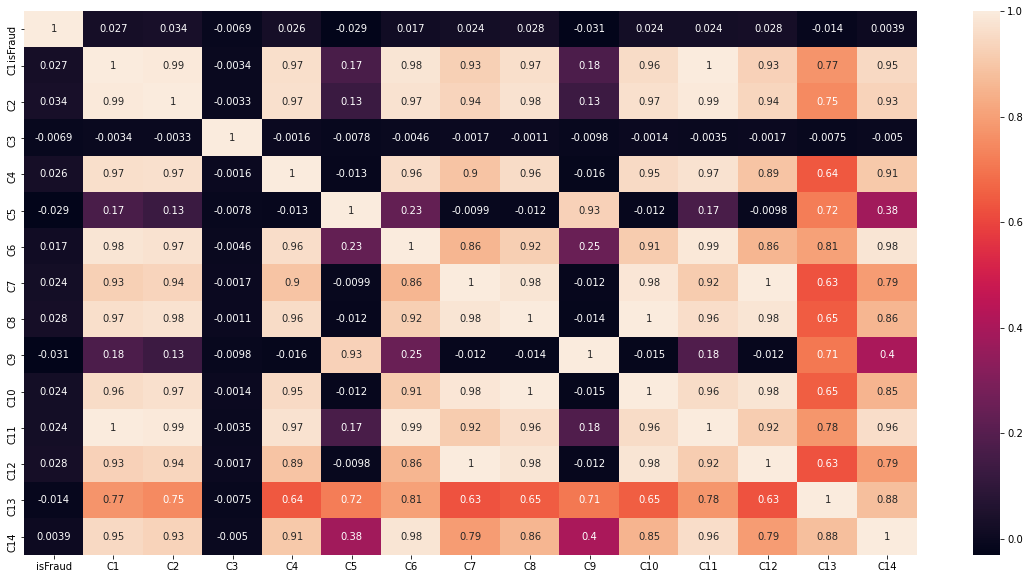

In [ ]:
df_C = fraud_df.loc[:,['isFraud','C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14']]
cor_C  = df_C.corr()
plt.figure(figsize=(20,10))
sns.heatmap(df_C.corr(), 
        xticklabels=df_C.columns,
        yticklabels=df_C.columns,annot=True)

In [ ]:
fraud_df = fraud_df.drop(columns= ['C2','C4','C6','C7','C8','C9','C10','C11','C12','C14'])

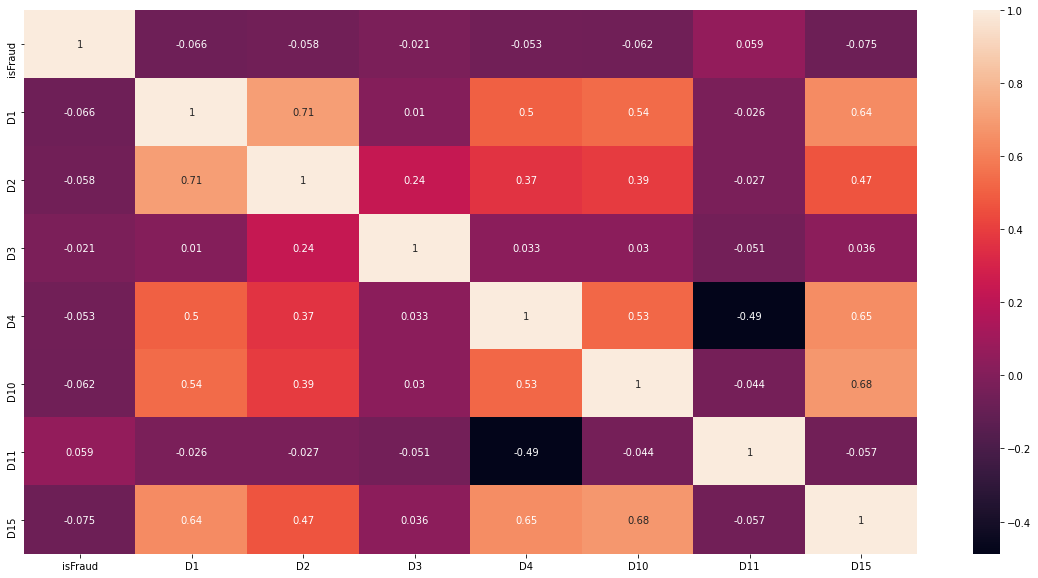

In [ ]:
df_D = fraud_df.loc[:,['isFraud','D1','D2','D3','D4','D10','D11','D15']]
cor_D  = df_D.corr()
plt.figure(figsize=(20,10))
sns.heatmap(df_D.corr(), 
        xticklabels=df_D.columns,
        yticklabels=df_D.columns,annot=True)


In [ ]:
fraud_df.shape

(100391, 212)

### 2.4 Label encoding categorical variables

In [ ]:
labelencoder = LabelEncoder()

lst = ['ProductCD','M1','M2','M3','M4','M6','emaild','card4_new','card6_new']
for col in lst: 
  fraud_df[col] = labelencoder.fit_transform(fraud_df[col])
fraud_df.head()

,Unnamed: 0,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,C1,C3,C5,C13,D1,D2,D3,D4,D10,D11,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,...,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,Day_of_Week_Tx,Hour_of_Day_Tx,ProductCD,M1,M2,M3,M4,M6,emaild,card4_new,card6_new,isFraud
0,0,0.429106,-0.307587,0.249458,-0.106313,-0.283015,0.599090,0.077481,0.074114,-0.098145,-0.036382,-0.176589,-0.189263,0.930379,0.406531,0.046946,1.872612,0.628290,0.495527,1.653359,0.010677,-0.189174,-0.243459,0.353205,0.260853,-0.190884,-0.238351,-0.148361,-0.182704,1.033909,0.945600,0.863531,0.756839,0.022693,-0.371119,-0.365375,-0.366787,-0.364027,0.432053,0.335506,...,-0.059294,-0.055906,-0.100951,-0.141964,-0.093984,-0.099479,-0.154221,-0.163039,-0.523434,-0.452780,-0.501426,0.0,-0.060223,-0.094656,-0.077421,-0.085832,-0.329029,-0.037032,-0.216329,-0.225491,-0.256123,-0.233358,-0.047958,-0.063173,-0.058487,-0.086097,-0.104802,-0.099922,-0.482151,-1.160565,4,1,1,1,0,1,9,2,2,0
1,1,-0.999674,6.085742,1.186828,-0.258555,-0.283015,-0.103036,0.077481,0.074114,-0.090555,-0.036382,-0.215468,-0.251638,-0.597109,-0.970459,0.511054,0.630161,-0.677875,-0.787244,0.480459,0.010677,-0.189174,-0.243459,0.353205,0.260853,-0.190884,-0.238351,-0.148361,-0.182704,-0.884308,-0.860731,0.863531,0.756839,0.022693,-0.371119,-0.365375,-0.366787,-0.364027,0.432053,0.335506,...,-0.059294,-0.055906,-0.100951,-0.141964,-0.093984,-0.099479,-0.154221,-0.163039,-0.523434,-0.452780,-0.501426,0.0,-0.060223,-0.094656,-0.077421,-0.085832,-0.329029,-0.037032,-0.216329,-0.225491,-0.256123,-0.233358,-0.047958,-0.063173,-0.058487,-0.086097,-0.104802,-0.099922,-0.482151,0.941072,4,1,1,0,2,0,43,3,2,0
2,2,-0.288092,-0.070604,-1.493906,-0.174649,-0.283015,-2.354682,0.077481,0.074114,-0.098145,-0.036382,-0.215468,-0.243841,-0.597109,-0.977974,-0.044294,-1.025059,-0.677875,-0.787244,-0.806268,0.010677,-0.189174,-0.243459,-1.925934,-1.838859,-0.190884,-0.238351,-0.148361,-0.182704,-0.884308,-0.860731,0.863531,0.756839,0.022693,-0.371119,-0.365375,-0.366787,-0.364027,-1.917154,-1.856215,...,-0.059294,-0.055906,-0.100951,-0.141964,-0.093984,-0.099479,-0.154221,-0.163039,-0.523434,-0.452780,-0.501426,0.0,-0.060223,-0.094656,-0.077421,-0.085832,-0.329029,-0.037032,-0.216329,-0.225491,-0.256123,-0.233358,-0.047958,-0.063173,-0.058487,-0.086097,-0.104802,-0.099922,0.984936,0.941072,4,1,1,1,0,1,39,1,1,0
3,3,-1.303831,-0.106924,-1.276649,0.953039,-0.283015,-0.805162,2.168024,0.074114,-0.098145,-0.036382,-0.176589,-0.251638,-0.597109,-0.920982,-0.099469,-0.732865,-0.677875,-0.787244,-0.806268,0.010677,-0.189174,-0.243459,0.353205,0.260853,-0.190884,-0.238351,-0.148361,-0.182704,1.033909,0.945600,0.863531,0.756839,0.022693,-0.371119,-0.365375,-0.366787,-0.364027,0.432053,0.335506,...,-0.059294,-0.055906,-0.100951,-0.141964,-0.093984,-0.099479,-0.154221,-0.163039,-0.523434,-0.452780,-0.501426,0.0,-0.060223,-0.094656,-0.077421,-0.085832,-0.329029,-0.037032,-0.216329,-0.225491,-0.256123,-0.233358,-0.047958,-0.063173,-0.058487,-0.086097,-0.104802,-0.099922,-1.460208,0.152958,4,1,1,1,0,0,15,3,2,0
4,4,-0.942181,-0.327710,0.257414,-1.647765,2.800073,0.647513,-0.146549,-9.785770,-0.098145,-0.036382,-0.215468,-0.243841,-0.597109,-0.936998,0.237195,-0.732865,-0.677875,14.135617,-0.806268,2.031698,0.248163,-1.557301,9.928612,8.789279,-7.653528,-20.216077,2.097850,-9.728162,3.687797,-2.919086,-1.094463,-1.124810,0.022693,2.622207,2.560572,2.338080,2.297143,0.432053,0.335506,...,-0.059294,-0.055906,-0.100951,-0.141964,-0.093984,-0.099479,-0.154221,-0.163039,1.545754,1.136192,1.384868,0.0,-0.060223,-0.094656,-0.077421,-0.085832,-0.329029,-0.037032,-0.216329,-0.225491,-0.256123,-0.233358,-0.047958,-0.063173,-0.058487,-0.086097,-0.104802,-0.099922,0.984936,1.203776,0,1,1,1,2,0,24,3,2,0


## 3. Balancing our dataset using SMOTE

In [ ]:
fraud_df.isFraud.value_counts()

0    96878
1     3513
Name: isFraud, dtype: int64

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(fraud_df[fraud_df.columns[fraud_df.columns!="isFraud"]],fraud_df.isFraud,random_state=45,test_size=.2)

In [ ]:
y_train.value_counts()

0    77464
1     2848
Name: isFraud, dtype: int64

In [ ]:
#Oversampling the data
smote = SMOTE(random_state = 101)
X_train, y_train = smote.fit_resample(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
fraud_df2 = pd.DataFrame(X_train, columns = fraud_df.drop(columns=['isFraud']).columns)
fraud_df2['isFraud'] = y_train

In [ ]:
fraud_df2.isFraud.value_counts()

1    77464
0    77464
Name: isFraud, dtype: int64

In [ ]:
fraud_df2.shape

(154928, 212)

## 4. Extracting Important features using baseline light GBM

### 4.1 Running light GBM to get important features

In [ ]:
gbm=GradientBoostingClassifier(random_state=45)
gbm.fit(X_train,y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=45, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
# Classification Report and best parameters
print(classification_report(y_true=y_test,y_pred=gbm.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     19414
           1       0.39      0.42      0.40       665

    accuracy                           0.96     20079
   macro avg       0.68      0.70      0.69     20079
weighted avg       0.96      0.96      0.96     20079



In [ ]:
imp_cols = pd.DataFrame({'columns':X_test.columns,'importance':gbm.feature_importances_})

In [ ]:
imp_cols.sort_values(by='importance',ascending=False,inplace=True)

In [ ]:
pd.set_option('display.max_rows', 500)

In [ ]:
# Below we get 110 variables which we will be using for modeling having feature importance greater then 0
len(imp_cols.loc[imp_cols['importance'] >0])

110

In [ ]:
imp_cols

,columns,importance
209,card6_new,0.209572
8,C1,0.098527
11,C13,0.091314
171,V294,0.072529
199,Day_of_Week_Tx,0.060184
206,M6,0.052567
208,card4_new,0.042022
108,V90,0.035344
112,V94,0.032114
205,M4,0.026159


In [ ]:
# AUC score for best model
y_score = gbm.predict_proba(X_test)[:,1]
fpr, tpr, threshold = roc_curve(y_test, y_score)
print('roc_auc_score for gbm: ', roc_auc_score(y_test, y_score))

roc_auc_score for gbm:  0.8525831680261744


### 4.2 Creating CSV files for important features to be used for modeling

In [ ]:
imp_cols_g0 = imp_cols.loc[imp_cols['importance'] >0]

In [ ]:
imp_colu = list(imp_cols_g0['columns'])

In [ ]:
cols_to_use = [col for col in fraud_df2.columns if col in imp_colu]

In [ ]:
cols_use_final = fraud_df2[cols_to_use]

In [ ]:
X_test.shape

In [ ]:
X_test = X_test[cols_to_use]

In [ ]:
X_test.shape

In [ ]:
y_test.shape

In [ ]:
X_train.shape

In [ ]:
X_train = cols_use_final.drop(columns=['isFraud'])

In [ ]:
cols_use_final['isFraud'] = y_train

In [ ]:
y_train.shape

In [ ]:
X_train.to_csv('X_train_over_imp.csv')

In [ ]:
X_test.to_csv('X_test_over_imp.csv')

In [ ]:
cols_use_final['isFraud'].to_csv('y_train_over_imp.csv')

In [ ]:
y_test.to_csv('y_test_over_imp.csv')

## 5. Modeling

### 5.1 Logistic Regression

In [ ]:
lr_X_train = pd.read_csv("X_train_over_imp.csv")
lr_X_train = lr_X_train.drop(columns=['Unnamed: 0'])
lr_X_train = lr_X_train.dropna()
lr_y_train = pd.read_csv("y_train_over_imp.csv")
lr_y_train = lr_y_train["isFraud"]
lr_X_test = pd.read_csv("X_test_over_imp.csv")
lr_X_test = lr_X_test.drop(columns=['Unnamed: 0'])
lr_X_test = lr_X_test.dropna()
lr_y_test = pd.read_csv("y_test_over_imp.csv")
lr_y_test = lr_y_test["isFraud"]

#### 5.1.1 Grid search for Logistic Regression

In [ ]:
logReg_param_grid = {'C': [-4,1,2,3,4,8, 13,15],
              'penalty': ['l1', 'l2'],
              'max_iter': [100,500,1000,1500]
             }
logReg = LogisticRegression()
logReg_grid = GridSearchCV(logReg, logReg_param_grid, cv=6, verbose=10, scoring='roc_auc', n_jobs=-1)
logReg_grid.fit(lr_X_train,lr_y_train)

Fitting 6 folds for each of 64 candidates, totalling 384 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1544s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Batch computation too slow (4.1986s.) Setting batch_size=1.
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   48.9s
[Parallel(n_jobs=-1)]: Done 203 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 244 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 279 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 344 out of 384 | elapsed:  7.5min remaining:   

GridSearchCV(cv=6, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [-4, 1, 2, 3, 4, 8, 13, 15],
                         'max_iter': [100, 500, 1000, 1500],
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=10)

In [ ]:
# Classification Report and best parameters for Grid Search
print(classification_report(y_true=lr_y_test,y_pred=logReg_grid.predict(lr_X_test)))
print("Best Parameters:")
logReg_bestParams = logReg_grid.best_params_.items()
for hps, values in logReg_bestParams:
  print(f"{hps}: {values}")

              precision    recall  f1-score   support

           0       0.99      0.75      0.85     19414
           1       0.09      0.74      0.16       665

    accuracy                           0.75     20079
   macro avg       0.54      0.74      0.51     20079
weighted avg       0.96      0.75      0.83     20079

Best Parameters:
C: 15
max_iter: 1500
penalty: l2


In [ ]:
# Saving grid search output of logistic regression in a csv file
tst = pd.DataFrame(logReg_grid.cv_results_)
tst.sort_values(by='mean_test_score',ascending=False,inplace=True)
tst = tst[["param_C","param_max_iter","param_penalty","mean_test_score"]]
tst = tst.dropna()
tst.to_csv("grid_otp_lr.csv")

#### 5.1.2 Running best model for Logistic Regression

In [ ]:
logoptm = LogisticRegression(C=15,max_iter=1500,penalty = 'l2')
logoptm.fit(lr_X_train,lr_y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=15, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
print(classification_report(y_true=lr_y_test,y_pred=logoptm.predict(lr_X_test)))

              precision    recall  f1-score   support

           0       0.99      0.75      0.85     19414
           1       0.09      0.74      0.16       665

    accuracy                           0.75     20079
   macro avg       0.54      0.74      0.51     20079
weighted avg       0.96      0.75      0.83     20079



In [ ]:
# AUC score for best model
y_score = logoptm.predict_proba(lr_X_test)[:,1]
fpr, tpr, threshold = roc_curve(lr_y_test, y_score)
print('roc_auc_score for LR: ', roc_auc_score(lr_y_test, y_score))

roc_auc_score for LR:  0.8130037930924974


In [ ]:
# Saving model in a pickle file
pickle.dump(logoptm, open("logoptm.pkl", 'wb'))

### 5.2 Random Forest

In [ ]:
rf_X_train = pd.read_csv("X_train_over_imp.csv")
rf_X_train = rf_X_train.drop(columns=['Unnamed: 0'])
rf_X_train = rf_X_train.dropna()

In [ ]:
rf_y_train = pd.read_csv("y_train_over_imp.csv")  

In [ ]:
rf_y_train = rf_y_train["isFraud"]

In [ ]:
rf_X_test = pd.read_csv("X_test_over_imp.csv")
rf_X_test = rf_X_test.drop(columns=['Unnamed: 0'])
rf_X_test = rf_X_test.dropna()

In [ ]:
rf_y_test = pd.read_csv("y_test_over_imp.csv")
rf_y_test = rf_y_test["isFraud"]

#### 5.2.1 Running baseline model for Random Forest

In [ ]:
rf = RandomForestClassifier()
rf.fit(rf_X_train,rf_y_train)

In [ ]:
print(classification_report(y_true=rf_y_test,y_pred=rf.predict(rf_X_test)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     19414
           1       0.76      0.38      0.51       665

    accuracy                           0.98     20079
   macro avg       0.87      0.69      0.75     20079
weighted avg       0.97      0.98      0.97     20079



In [ ]:
# AUC score for best model
y_score = rf.predict_proba(rf_X_test)[:,1]
fpr, tpr, threshold = roc_curve(rf_y_test, y_score)
print('roc_auc_score for RF: ', roc_auc_score(y_test, y_score))

roc_auc_score for LR:  0.8922767152763954


#### 5.2.2 Running grid search for Random Forest

In [ ]:
param_grid_rf={'max_depth': [25,50, 100],
            'max_features': ['auto', 'sqrt'],
            'min_samples_leaf': [10,50,100],
            'min_samples_split': [2000,4000,8000],
            'n_estimators': [500, 1000,2000]}
rf_grid = GridSearchCV(rf, param_grid_rf, scoring='roc_auc',cv = 5,verbose=1,n_jobs=-1)

In [ ]:
rf_grid.fit(rf_X_train,rf_y_train)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed: 32.8min
[Parallel(n_jobs=-1)]: Done 370 tasks      | elapsed: 94.1min
[Parallel(n_jobs=-1)]: Done 720 tasks      | elapsed: 181.2min
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed: 201.6min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [ ]:
# Classification Report and best parameters for Grid Search
print(classification_report(y_true=rf_y_test,y_pred=rf_grid.predict(rf_X_test)))
print("Best Parameters:")
rf_grid_bestParams = rf_grid.best_params_.items()
for hps, values in rf_grid_bestParams:
  print(f"{hps}: {values}")

              precision    recall  f1-score   support

           0       0.99      0.90      0.94     19414
           1       0.17      0.62      0.27       665

    accuracy                           0.89     20079
   macro avg       0.58      0.76      0.61     20079
weighted avg       0.96      0.89      0.92     20079

Best Parameters:
max_depth: 25
max_features: auto
min_samples_leaf: 10
min_samples_split: 2000
n_estimators: 2000


In [ ]:
# AUC score for best model
y_score = rf_grid.predict_proba(rf_X_test)[:,1]
fpr, tpr, threshold = roc_curve(rf_y_test, y_score)
print('roc_auc_score for RF: ', roc_auc_score(rf_y_test, y_score))

roc_auc_score for RF:  0.8654927728303967


In [ ]:
# Saving grid search output of logistic regression in a csv file
tstrf = pd.DataFrame(rf_grid.cv_results_)
tstrf.sort_values(by='mean_test_score',ascending=False,inplace=True)

In [ ]:
tstrf = tstrf[["param_max_depth","param_max_features","param_min_samples_leaf","param_min_samples_split","param_n_estimators","mean_test_score"]]
tstrf = tstrf.dropna()
tstrf.to_csv("grid_otp_rf.csv")

In [ ]:
len(tstrf)

162

#### 5.2.3 Running best model for Random Forest

In [ ]:
rfopt = RandomForestClassifier(max_depth=25,max_features='auto',min_samples_leaf=10,min_samples_split=2000,n_estimators=2000,n_jobs=-1)
rfopt.fit(rf_X_train,rf_y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=25, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2000,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [ ]:
print(classification_report(y_true=rf_y_test,y_pred=rfopt.predict(rf_X_test)))

              precision    recall  f1-score   support

           0       0.99      0.90      0.94     19414
           1       0.17      0.62      0.27       665

    accuracy                           0.89     20079
   macro avg       0.58      0.76      0.61     20079
weighted avg       0.96      0.89      0.92     20079



In [ ]:
# AUC score for best model
y_score = rfopt.predict_proba(rf_X_test)[:,1]
fpr, tpr, threshold = roc_curve(rf_y_test, y_score)
print('roc_auc_score for RF: ', roc_auc_score(rf_y_test, y_score))

roc_auc_score for LR:  0.8655131441460354


In [ ]:
# Saving model in a pickle file
pickle.dump(rfopt, open("rfoptm.pkl", 'wb'))

### 5.3 Extreme Gradient Boosting

In [ ]:
xgb_X_train = pd.read_csv("X_train_over_imp.csv")
xgb_X_train = xgb_X_train.drop(columns=['Unnamed: 0'])
xgb_X_train = xgb_X_train.dropna()
xgb_y_train = pd.read_csv("y_train_over_imp.csv")
xgb_y_train = xgb_y_train["isFraud"]
xgb_X_test = pd.read_csv("X_test_over_imp.csv")
xgb_X_test = xgb_X_test.drop(columns=['Unnamed: 0'])
xgb_X_test = xgb_X_test.dropna()
xgb_y_test = pd.read_csv("y_test_over_imp.csv")
xgb_y_test = xgb_y_test["isFraud"]

#### 5.3.1 Running randomized search for extreme gradient boosting

In [ ]:
xgb = XGBClassifier(seed=45)
param_grid_xgb = {'max_depth':[18,10,15], 'subsample':[0.4,0.6,0.8], 'learning_rate': [0.02,0.2,0.05],'n_estimators': [500, 1000,2000],'gamma':[0.5,0.8,0.2]}
xgb_grid_r = RandomizedSearchCV(xgb, param_grid_xgb, scoring='roc_auc',cv = 5,verbose=1,n_jobs=-1)

In [ ]:
xgb_grid_r.fit(xgb_X_train,xgb_y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  50 | elapsed: 30.7min remaining: 188.5min
[Parallel(n_jobs=-1)]: Done  13 out of  50 | elapsed: 45.3min remaining: 128.9min
[Parallel(n_jobs=-1)]: Done  19 out of  50 | elapsed: 78.0min remaining: 127.3min
[Parallel(n_jobs=-1)]: Done  25 out of  50 | elapsed: 87.8min remaining: 87.8min
[Parallel(n_jobs=-1)]: Done  31 out of  50 | elapsed: 90.0min remaining: 55.1min
[Parallel(n_jobs=-1)]: Done  37 out of  50 | elapsed: 97.4min remaining: 34.2min
[Parallel(n_jobs=-1)]: Done  43 out of  50 | elapsed: 102.1min remaining: 16.6min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 129.2min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, sc...ht=1,
                                           seed=45, silent=None, subsample=1,
                                           verbosity=1),
                   iid='deprecated', 

In [ ]:
# Classification Report and best parameters for Grid Search
print(classification_report(y_true=xgb_y_test,y_pred=xgb_grid_r.predict(xgb_X_test)))
print("Best Parameters:")
xgb_grid_r_bestParams = xgb_grid_r.best_params_.items()
for hps, values in xgb_grid_r_bestParams:
  print(f"{hps}: {values}")

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     19414
           1       0.84      0.40      0.54       665

    accuracy                           0.98     20079
   macro avg       0.91      0.70      0.77     20079
weighted avg       0.98      0.98      0.97     20079

Best Parameters:
subsample: 0.4
n_estimators: 500
max_depth: 18
learning_rate: 0.02
gamma: 0.8


In [ ]:
# AUC score for best model
y_score = xgb_grid_r.predict_proba(xgb_X_test)[:,1]
fpr, tpr, threshold = roc_curve(xgb_y_test, y_score)
print('roc_auc_score for xgb: ', roc_auc_score(xgb_y_test, y_score))

roc_auc_score for LR:  0.9151932447787853


In [ ]:
# Saving grid search output of logistic regression in a csv file
tstxgb = pd.DataFrame(xgb_grid_r.cv_results_)
tstxgb.sort_values(by='mean_test_score',ascending=False,inplace=True)

In [ ]:
tstxgb = tstxgb[["param_max_depth","param_subsample","param_learning_rate","param_n_estimators","param_gamma","mean_test_score"]]
tstxgb = tstxgb.dropna()
tstxgb.to_csv("grid_otp_xgb.csv")

#### 5.3.2 Running best model for Extreme Gradient Boosting

In [ ]:
xgb_opt = XGBClassifier(subsample=0.4,n_estimators=500,max_depth=18,learning_rate=0.02,gamma=0.8,subseed=45,n_jobs=-1)
xgb_opt.fit(xgb_X_train,xgb_y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.8,
              learning_rate=0.02, max_delta_step=0, max_depth=18,
              min_child_weight=1, missing=None, n_estimators=500, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.4, subseed=45, verbosity=1)

In [ ]:
print(classification_report(y_true=xgb_y_test,y_pred=xgb_opt.predict(xgb_X_test)))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     19414
           1       0.83      0.41      0.55       665

    accuracy                           0.98     20079
   macro avg       0.90      0.70      0.77     20079
weighted avg       0.98      0.98      0.97     20079



In [ ]:
# AUC score for best model
y_score = xgb_opt.predict_proba(xgb_X_test)[:,1]
fpr, tpr, threshold = roc_curve(xgb_y_test, y_score)
print('roc_auc_score for xgb: ', roc_auc_score(xgb_y_test, y_score))

roc_auc_score for LR:  0.915656789031402


In [ ]:
# Saving model in a pickle file
pickle.dump(xgb_opt, open("xgboptm.pkl", 'wb'))

### 5.4 Naive Bayes

In [ ]:
nb_X_train = pd.read_csv("X_train_over_imp.csv")
nb_X_train = nb_X_train.drop(columns=['Unnamed: 0'])
nb_X_train = nb_X_train.dropna()
nb_y_train = pd.read_csv("y_train_over_imp.csv")
nb_y_train = nb_y_train["isFraud"]
nb_X_test = pd.read_csv("X_test_over_imp.csv")
nb_X_test = nb_X_test.drop(columns=['Unnamed: 0'])
nb_X_test = nb_X_test.dropna()
nb_y_test = pd.read_csv("y_test_over_imp.csv")
nb_y_test = nb_y_test["isFraud"]

In [ ]:
scale_minmax01 = MinMaxScaler(feature_range=(0, 1))
sca_min_max_train = scale_minmax01.fit_transform(nb_X_train)
nb_X_train = pd.DataFrame(sca_min_max_train, columns=nb_X_train.columns, index=nb_X_train.index)

In [ ]:
scale_minmax01 = MinMaxScaler(feature_range=(0, 1))
sca_min_max_train = scale_minmax01.fit_transform(nb_X_test)
nb_X_test = pd.DataFrame(sca_min_max_train, columns=nb_X_test.columns, index=nb_X_test.index)

In [ ]:
nb_X_train.shape

(154928, 110)

#### 5.4.1 Running baseline model for Naive Bayes

In [ ]:
mnb = MultinomialNB()
mnb.fit(nb_X_train, nb_y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
print(classification_report(y_true=nb_y_test,y_pred=mnb.predict(nb_X_test)))

              precision    recall  f1-score   support

           0       0.98      0.79      0.88     19414
           1       0.08      0.54      0.14       665

    accuracy                           0.78     20079
   macro avg       0.53      0.67      0.51     20079
weighted avg       0.95      0.78      0.85     20079



In [ ]:
# AUC score for best model
y_score = mnb.predict_proba(nb_X_test)[:,1]
fpr, tpr, threshold = roc_curve(nb_y_test, y_score)
print('roc_auc_score for NB: ', roc_auc_score(nb_y_test, y_score))

roc_auc_score for nb:  0.7506561035327579


#### 5.4.2 Running grid search for Naive Bayes

In [ ]:
param_grid_mnb = {'alpha': [0.1, 0.01, 2, 3, 4, 5, 6, 7, 8, 9, 0.001, 0.0001],'fit_prior':['True','False']}
mnb_grid = GridSearchCV(mnb, param_grid_mnb, cv=5,scoring='roc_auc',verbose=1,n_jobs=-1)
mnb_grid.fit(nb_X_train,nb_y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    4.9s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [0.1, 0.01, 2, 3, 4, 5, 6, 7, 8, 9, 0.001,
                                   0.0001],
                         'fit_prior': ['True', 'False']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='roc_auc', verbose=1)

In [ ]:
# Classification Report and best parameters for Grid Search
print(classification_report(y_true=nb_y_test,y_pred=mnb_grid.predict(nb_X_test)))
print("Best Parameters:")
nb_grid_r_bestParams = mnb_grid.best_params_.items()
for hps, values in nb_grid_r_bestParams:
  print(f"{hps}: {values}")

              precision    recall  f1-score   support

           0       0.98      0.79      0.88     19414
           1       0.08      0.54      0.14       665

    accuracy                           0.78     20079
   macro avg       0.53      0.67      0.51     20079
weighted avg       0.95      0.78      0.85     20079

Best Parameters:
alpha: 7
fit_prior: True


In [ ]:
# AUC score for best model
y_score = mnb_grid.predict_proba(nb_X_test)[:,1]
fpr, tpr, threshold = roc_curve(nb_y_test, y_score)
print('roc_auc_score for NB: ', roc_auc_score(nb_y_test, y_score))

roc_auc_score for LR:  0.75058344842223


In [ ]:
# Saving grid search output of logistic regression in a csv file
tstnb = pd.DataFrame(mnb_grid.cv_results_)
tstnb.sort_values(by='mean_test_score',ascending=False,inplace=True)

In [ ]:
tstnb = tstnb[["param_alpha","param_fit_prior","mean_test_score"]]
tstnb = tstnb.dropna()
tstnb.to_csv("grid_otp_nb.csv")

#### 5.4.3 Running best model for Naive Bayes

In [ ]:
nbotp = MultinomialNB(alpha=7,fit_prior=True)
nbotp.fit(nb_X_train,nb_y_train)

MultinomialNB(alpha=7, class_prior=None, fit_prior=True)

In [ ]:
print(classification_report(y_true=nb_y_test,y_pred=nbotp.predict(nb_X_test)))

              precision    recall  f1-score   support

           0       0.98      0.79      0.88     19414
           1       0.08      0.54      0.14       665

    accuracy                           0.78     20079
   macro avg       0.53      0.67      0.51     20079
weighted avg       0.95      0.78      0.85     20079



In [ ]:
# AUC score for best model
y_score = nbotp.predict_proba(nb_X_test)[:,1]
fpr, tpr, threshold = roc_curve(nb_y_test, y_score)
print('roc_auc_score for NB: ', roc_auc_score(nb_y_test, y_score))

roc_auc_score for LR:  0.75058344842223


In [ ]:
# Saving model in a pickle file
pickle.dump(nbotp, open("nboptm.pkl", 'wb'))